--- Starting Task 1: Data Preprocessing and Exploration ---


--- Data Cleaning & Basic Statistics ---
Initial data shape: (2285, 3)
Missing values per column:
 Ticker
BND     0
SPY     0
TSLA    0
dtype: int64

Descriptive statistics:
 Ticker          BND          SPY         TSLA
count   2285.000000  2285.000000  2285.000000
mean      68.123587   307.529086   113.393781
std        4.661419   102.147084   110.564796
min       60.779160   155.869736     9.578000
25%       64.482208   221.050400    17.851334
50%       67.020836   275.265564    30.102667
75%       71.545227   397.105988   217.720001
max       77.318268   557.911133   409.970001


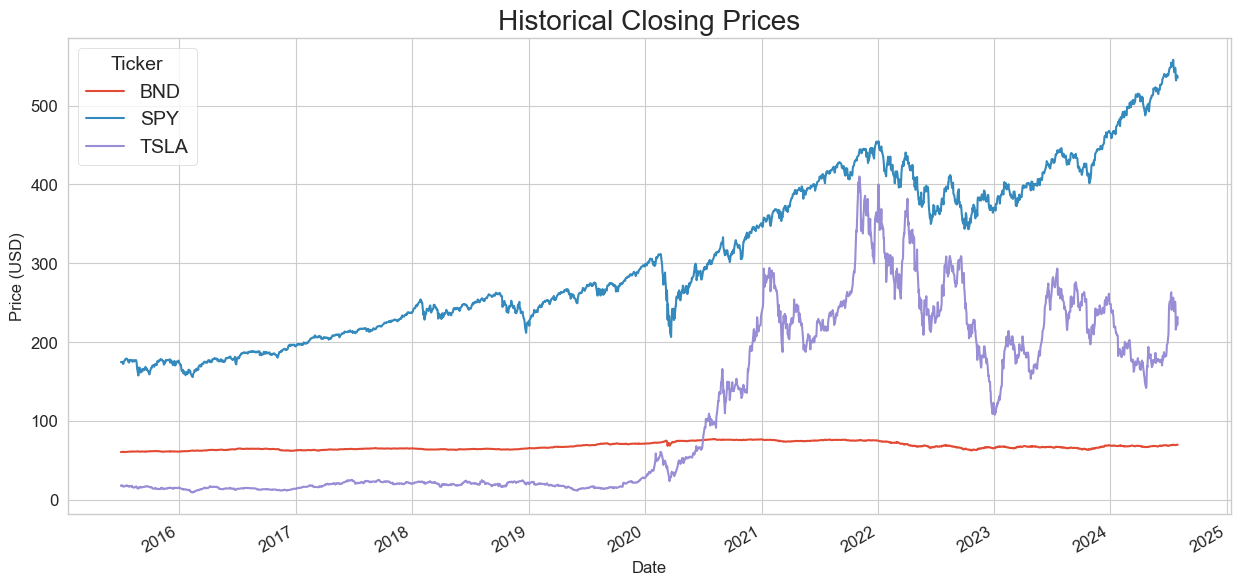

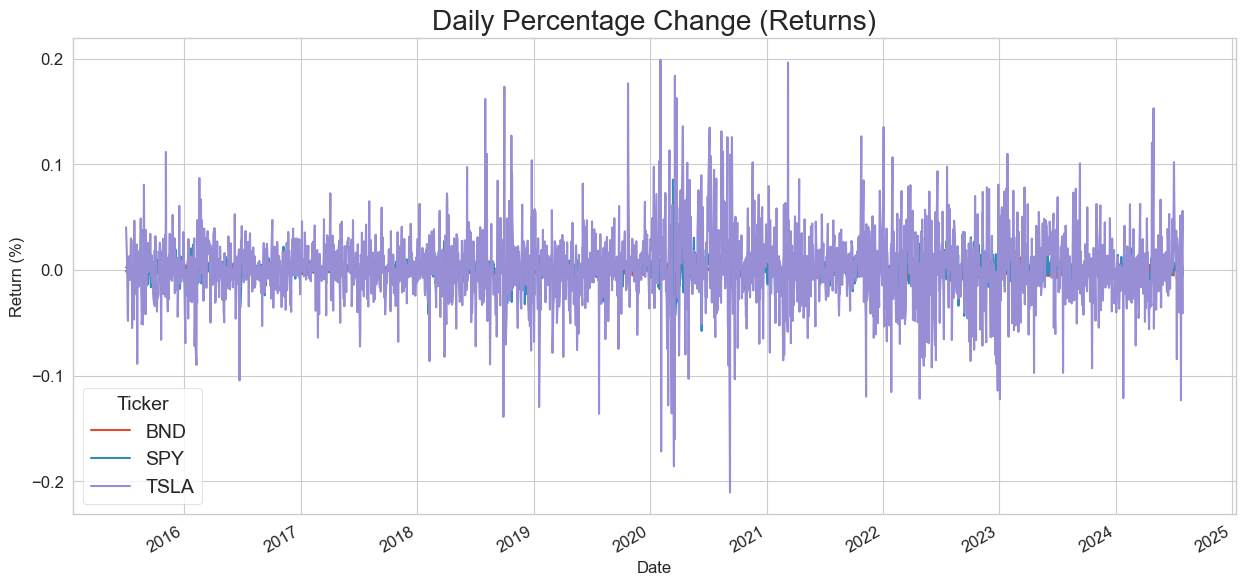

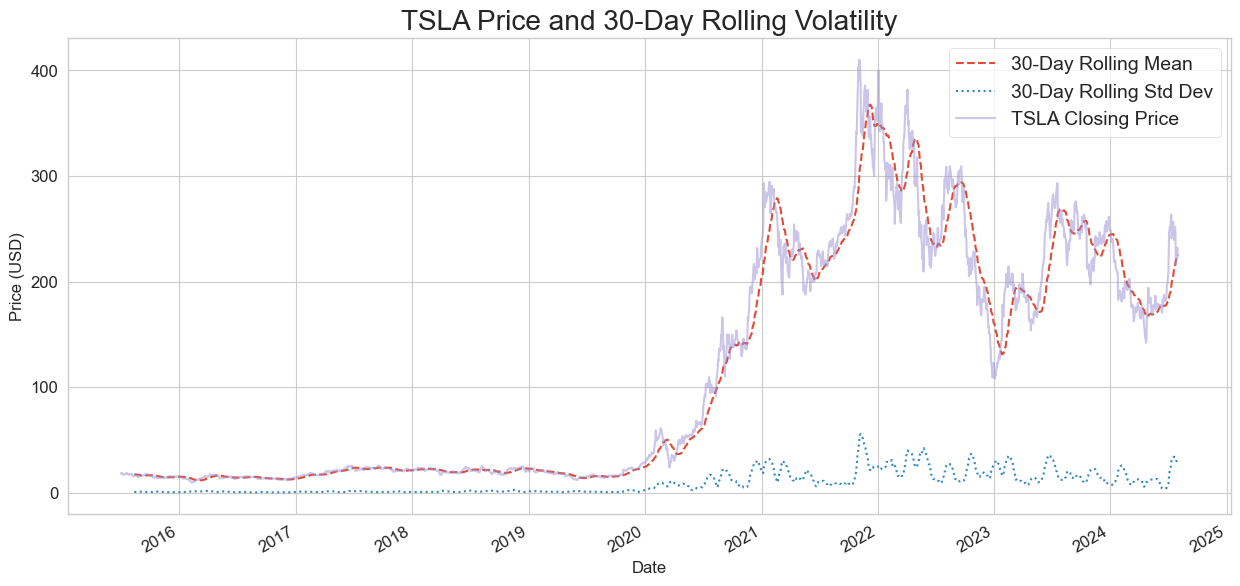

<Figure size 1000x600 with 0 Axes>

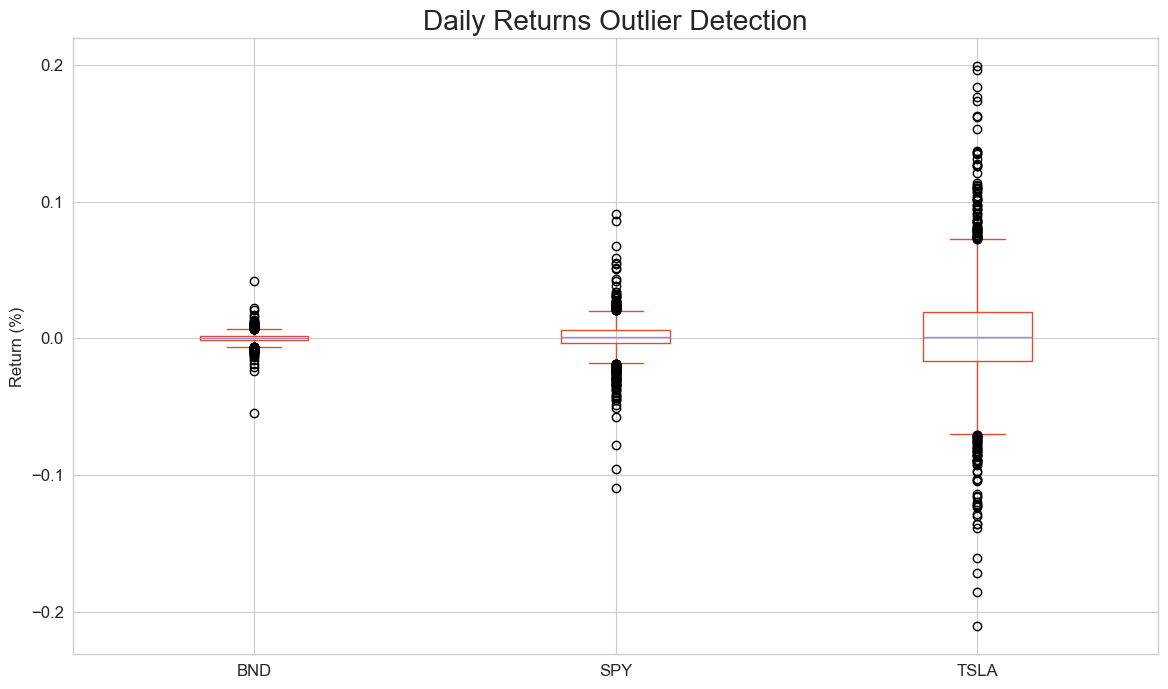


Augmented Dickey-Fuller Test for TSLA Closing Price:
  ADF Statistic: -1.2893
  p-value: 0.6341
  Conclusion: The series is NOT stationary at the 5% significance level.

Augmented Dickey-Fuller Test for BND Closing Price:
  ADF Statistic: -1.5753
  p-value: 0.4960
  Conclusion: The series is NOT stationary at the 5% significance level.

Augmented Dickey-Fuller Test for SPY Closing Price:
  ADF Statistic: 0.3061
  p-value: 0.9776
  Conclusion: The series is NOT stationary at the 5% significance level.

Augmented Dickey-Fuller Test for TSLA Daily Returns:
  ADF Statistic: -47.8298
  p-value: 0.0000
  Conclusion: The series is stationary at the 5% significance level.

--- Foundational Risk Metrics for TSLA ---
  - Annualized Return: 32.03%
  - Annualized Volatility: 57.54%
  - Sharpe Ratio: 0.56
  - Value at Risk (VaR) at 5.0%: -5.25%

--- Foundational Risk Metrics for BND ---
  - Annualized Return: 1.59%
  - Annualized Volatility: 5.53%
  - Sharpe Ratio: 0.29
  - Value at Risk (VaR) at 

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# --- TASK 1: PREPROCESS AND EXPLORE THE DATA ---
print("--- Starting Task 1: Data Preprocessing and Exploration ---")

# 1. Data Extraction
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-07-01'
end_date = '2024-07-31'

try:
    print(f"\nDownloading data for {', '.join(tickers)} from Yahoo Finance...")
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
except Exception as e:
    print(f"Error fetching data: {e}")
    print("Creating mock data due to download error.")
    dates = pd.date_range(start=start_date, end=end_date, freq='B')
    mock_data = pd.DataFrame(
        {('Close', 'TSLA'): np.random.rand(len(dates)) * 1000 + 100,
         ('Close', 'BND'): np.random.rand(len(dates)) * 10 + 80,
         ('Close', 'SPY'): np.random.rand(len(dates)) * 50 + 400},
        index=dates
    )
    data = mock_data.ffill()

# Drop the multi-index and focus on 'Close' prices
close_prices = data['Close'].dropna()

# 2. Data Cleaning and Understanding
print("\n--- Data Cleaning & Basic Statistics ---")
print("Initial data shape:", close_prices.shape)
print("Missing values per column:\n", close_prices.isnull().sum())
print("\nDescriptive statistics:\n", close_prices.describe())

# 3. Exploratory Data Analysis (EDA)

# Visualize closing prices over time
plt.figure(figsize=(15, 7))
close_prices.plot(title='Historical Closing Prices', ax=plt.gca())
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

# Calculate and plot daily returns
daily_returns = close_prices.pct_change().dropna()
plt.figure(figsize=(15, 7))
daily_returns.plot(title='Daily Percentage Change (Returns)', ax=plt.gca())
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.grid(True)
plt.show()

# Analyze volatility with rolling mean and standard deviation
plt.figure(figsize=(15, 7))
close_prices['TSLA'].rolling(window=30).mean().plot(label='30-Day Rolling Mean', linestyle='--')
close_prices['TSLA'].rolling(window=30).std().plot(label='30-Day Rolling Std Dev', linestyle=':')
plt.plot(close_prices['TSLA'], label='TSLA Closing Price', alpha=0.5)
plt.title('TSLA Price and 30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Outlier detection using a box plot
plt.figure(figsize=(10, 6))
daily_returns.plot.box(title='Daily Returns Outlier Detection')
plt.ylabel('Return (%)')
plt.grid(True)
plt.show()

# 4. Seasonality and Trends (Stationarity Test)

def adf_test(series, name):
    """Performs and prints the results of the Augmented Dickey-Fuller test."""
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"\nAugmented Dickey-Fuller Test for {name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {p_value:.4f}")
    is_stationary = "is stationary" if p_value < 0.05 else "is NOT stationary"
    print(f"  Conclusion: The series {is_stationary} at the 5% significance level.")

# Test closing prices for stationarity
adf_test(close_prices['TSLA'], 'TSLA Closing Price')
adf_test(close_prices['BND'], 'BND Closing Price')
adf_test(close_prices['SPY'], 'SPY Closing Price')

# Test daily returns for stationarity
adf_test(daily_returns['TSLA'], 'TSLA Daily Returns')

# 5. Risk Metrics Calculation

def calculate_risk_metrics(returns_series, name, confidence_level=0.05):
    """Calculates and prints VaR and Sharpe Ratio."""
    annualized_returns = (1 + returns_series).prod()**(252/len(returns_series)) - 1
    annualized_volatility = returns_series.std() * np.sqrt(252)
    sharpe_ratio = annualized_returns / annualized_volatility

    # VaR (historical method)
    VaR = returns_series.quantile(confidence_level)

    print(f"\n--- Foundational Risk Metrics for {name} ---")
    print(f"  - Annualized Return: {annualized_returns:.2%}")
    print(f"  - Annualized Volatility: {annualized_volatility:.2%}")
    print(f"  - Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"  - Value at Risk (VaR) at {confidence_level*100}%: {VaR:.2%}")

calculate_risk_metrics(daily_returns['TSLA'], 'TSLA')
calculate_risk_metrics(daily_returns['BND'], 'BND')
calculate_risk_metrics(daily_returns['SPY'], 'SPY')

print("\n--- Task 1 Complete ---")
